#**SUMMARY**

Filename    : model.ipynb   
Description : The file contains logic for creating model

Below steps were performed for data preparation,   
      1.   Building a pneumonia detection model starting from basic CNN and then   improving upon it.   
      2.   Train the model     
      3.   To deal with large training time, save the weights so that you can use them when training the model for the second time without starting from scratch.   


**Revision History**  
Date        ||       Description               ||              Author  
07-06-2020   ||   Initial logic for model creation   ||   Arvindh     
10-06-2020   ||   Model with Unet architecture   ||   Arvindh     
13-06-2020   ||   Model Testing - with test images  ||   Arvindh 
  



#**Import Libraries**

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow
import keras
from keras import backend as k
print("Backend: " + k.backend() + " || tensorflow version: " + tensorflow.__version__)

Backend: tensorflow || tensorflow version: 2.2.0


Using TensorFlow backend.


In [3]:
import pandas as pd 
import numpy as np
from matplotlib.pyplot import figure, show
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [4]:
!pip3 install pydicom
import pydicom
from skimage.transform import resize
import pickle
import cv2

     |████████████████████████████████| 35.5MB 90kB/s 


In [5]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
#Set your project path 
project_path =  'drive/My Drive/Colab Notebooks/Capstone'

In [8]:
#changed the project base path
os.chdir(project_path)

In [9]:
#Set your data path 
train_img_path = 'dataset/stage_2_train_images'
valid_img_path = 'dataset/stage_2_train_images'
test_img_path = 'dataset/stage_2_test_images'

In [10]:
train_df_pick = "train_df_pickle"
valid_df_pick = "valid_df_pickle"

# we open the file for reading
fileObject = open(train_df_pick,'rb')  
fileObject1 = open(valid_df_pick,'rb')  

# load the object from the file into temp var b
train_df = pickle.load(fileObject)  
valid_df = pickle.load(fileObject1) 

In [11]:
train_patient_Ids = train_df.patientId.unique()
print(train_df.shape, 'training data')
print("The number of unique patient id in the training dataset is "+ str(train_patient_Ids.shape[0]))

(24181, 10) training data
The number of unique patient id in the training dataset is 21908


Splitted the Validation dataset into Validation and Test dataset with the ratio of 95:5 based on the 'Target' column.

In [12]:
from sklearn.model_selection import train_test_split
valid_train_df, valid_test_df = train_test_split(valid_df, test_size=0.05,
                                    stratify=valid_df['Target'])
valid_train_patient_Ids = valid_train_df.patientId.unique()
valid_test_patient_Ids = valid_test_df.patientId.unique()
print(valid_train_df.shape, 'validation data')
print("The number of unique patient id in the validation dataset is "+ str(valid_train_patient_Ids.shape[0]))
print("---------------------------------------------------------------------")
print(valid_test_df.shape, 'test data')
print("The number of unique patient id in the test dataset is "+ str(valid_test_patient_Ids.shape[0]))

(5743, 10) validation data
The number of unique patient id in the validation dataset is 5620
---------------------------------------------------------------------
(303, 10) test data
The number of unique patient id in the test dataset is 301


#Custom Data generator

In [71]:
class Generator(keras.utils.Sequence):
  def __init__(self, unique_patient_ids, folder, dataframe, batch_size=100, shuffle=False, image_size=256, predict=False):
        self.unique_patient_ids = unique_patient_ids
        self.folder = folder
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = image_size
        self.predict = predict
        self.on_epoch_end()
   
  def __load__(self, pat_id):
        patIdWithExt = pat_id+'.dcm'
        # load dicom file from pixel array
        img = pydicom.dcmread(os.path.join(self.folder, patIdWithExt)).pixel_array
        # create empty array
        msk = np.zeros(img.shape) 
        
        if pat_id in self.dataframe["patientId"].values:
            pat_info = self.dataframe[self.dataframe.patientId == pat_id]

            # loop through patient rows in the df
            for info in pat_info.iterrows():
                row = info[1]
                if row.Target == 1:
                    x = int(row.x)
                    y = int(row.y)
                    msk[y: int(row.y) + int(row.height), x: int(row.x) + int(row.width)] = 1 
      
        img = cv2.resize(img, (self.image_size, self.image_size))
        msk = cv2.resize(msk, (self.image_size, self.image_size))
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)   

        #img2 = np.concatenate((img,)*3, axis=-1) 
        #msk2 = np.concatenate((msk,)*3, axis=-1)
        return img, msk

  def __loadpredict__(self, pat_id):
        patIdWithExt = pat_id+'.dcm'
        # load dicom file from pixel array
        img = pydicom.dcmread(os.path.join(self.folder, patIdWithExt)).pixel_array
        # resize image
        img = cv2.resize(img, (self.image_size, self.image_size))
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img

  def __getitem__(self, index):
        # select pat_ids by batches
        batch_pat_ids = self.unique_patient_ids[index*self.batch_size : (index+1)*self.batch_size]

        if self.predict:
            # load files
            imgs = [self.__loadpredict__(pat_id_row) for pat_id_row in batch_pat_ids]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, batch_pat_ids
        else:    
            # load pat ids by loop
            items = [self.__load__(pat_id_row) for pat_id_row in batch_pat_ids]
            imgs, msks = zip(*items)

            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
        return imgs, msks

  def __len__(self):
        if self.predict:
            return int(np.ceil(len(self.unique_patient_ids) / self.batch_size))
        else:
            # __len__ provides number of batches per epoch
            return int(np.floor(self.unique_patient_ids.shape[0] / self.batch_size))

  def on_epoch_end(self):
        if self.predict:
            self.indexes = np.arange(len(self.unique_patient_ids))
        else:
            self.indexes = np.arange(self.unique_patient_ids.shape[0])
        if self.shuffle == True:
              np.random.shuffle(self.indexes)

In [14]:
BATCH_SIZE = 64

In [15]:
train_gen = Generator(train_patient_Ids, train_img_path, train_df, batch_size=BATCH_SIZE, image_size=256)
valid_gen = Generator(valid_train_patient_Ids, valid_img_path, valid_train_df, batch_size=BATCH_SIZE, image_size=256)

#**Model Building**

In [42]:
def create_downsample(filters, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(filters, inputs):  #create residual block
  x = keras.layers.BatchNormalization(momentum = 0.9)(inputs)
  x = keras.layers.LeakyReLU(0)(x)
  x = keras.layers.Conv2D(filters, 3, padding = 'same', use_bias = False)(x)
  x = keras.layers.BatchNormalization(momentum = 0.9)(x)
  x = keras.layers.LeakyReLU(0)(x)
  x = keras.layers.Conv2D(filters, 3, padding = 'same', use_bias = False)(x)
  return keras.layers.add([x, inputs])

def create_cnn_model(input_size, n_blocks = 1, depth = 4):
  inputs = keras.Input(shape=(input_size, input_size, 1))
  x = keras.layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)

  filters = 32
  for d in range(depth):
        filters = filters * 2
        x = create_downsample(filters, x)
        for b in range(n_blocks):
              x = create_resblock(filters, x)
  
  x = keras.layers.BatchNormalization(momentum=0.9)(x)
  x = keras.layers.LeakyReLU(0)(x)
  x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
  outputs = keras.layers.UpSampling2D(2**depth)(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [46]:
model = create_cnn_model(input_size=256)
model.compile(optimizer="SGD", loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_Unet_2.h5", monitor="val_loss", verbose=1,
                             mode="auto", period=1)
stop = EarlyStopping(monitor="val_loss", patience=10, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 256, 256, 32) 128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 256, 256, 32) 0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [47]:
history = model.fit_generator(train_gen, 
                              validation_data=valid_gen, 
                              callbacks=[checkpoint, reduce_lr, stop],
                              epochs=7, 
                              workers=15, 
                              steps_per_epoch=len(train_gen),
                              validation_steps= len(valid_gen)//BATCH_SIZE,
                              use_multiprocessing=True)

Epoch 1/7
342/342 [==============================] - 1053s 3s/step - loss: 0.1114 - accuracy: 0.9723 - val_loss: 0.1293 - val_accuracy: 0.9614

Epoch 00001: saving model to model_Unet_2.h5
Epoch 2/7
342/342 [==============================] - 469s 1s/step - loss: 0.0861 - accuracy: 0.9741 - val_loss: 0.0684 - val_accuracy: 0.9805

Epoch 00002: saving model to model_Unet_2.h5
Epoch 3/7
342/342 [==============================] - 468s 1s/step - loss: 0.0820 - accuracy: 0.9743 - val_loss: 0.0854 - val_accuracy: 0.9708

Epoch 00003: saving model to model_Unet_2.h5
Epoch 4/7
342/342 [==============================] - 457s 1s/step - loss: 0.0796 - accuracy: 0.9744 - val_loss: 0.1080 - val_accuracy: 0.9602

Epoch 00004: saving model to model_Unet_2.h5
Epoch 5/7
342/342 [==============================] - 477s 1s/step - loss: 0.0783 - accuracy: 0.9745 - val_loss: 0.0731 - val_accuracy: 0.9800

Epoch 00005: saving model to model_Unet_2.h5
Epoch 6/7
342/342 [==============================] - 474s 1

In [ ]:
#Load the model from saved file
from keras.models import load_model
model1 = load_model('model_Unet_2.h5')
model1.summary()

#**Note** The model with UNet architecture has given good accuracy in the training and validation dataset.
Training - Accuracy: 97%, Loss: 6%   
Validation - Accuracy: 97%, Loss: 5%

The IOU value metric is around 48% in both Validation and Training dataset, which is considerably low, need to be increased with the performance tuning.

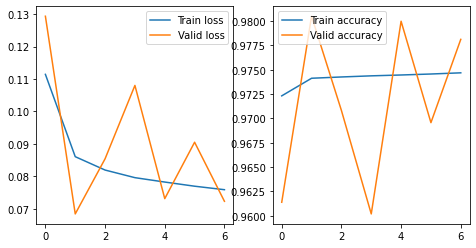

In [48]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.show()

#**Model Testing**

**Note** The Model has been tested for few test samples for to see the model predictions and compare with the model training.

In [17]:
#valid_test_samples = valid_test_df[valid_test_df.Target == 1].patientId.unique()

In [104]:
#test_gen = Generator(valid_test_samples, valid_img_path, valid_test_df, batch_size=1, image_size=256, predict=True)
test_gen = Generator(valid_test_patient_Ids, valid_img_path, valid_test_df, batch_size=1, image_size=256, predict=True)

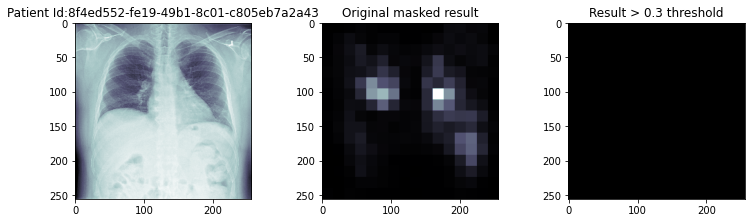

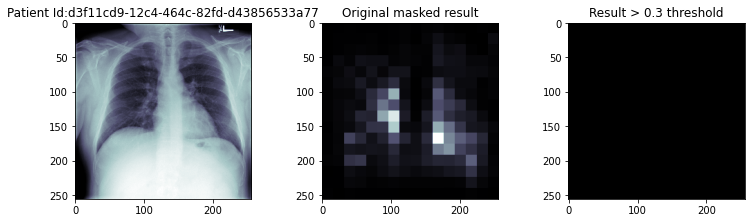

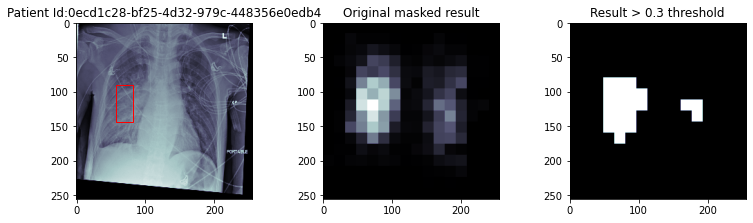

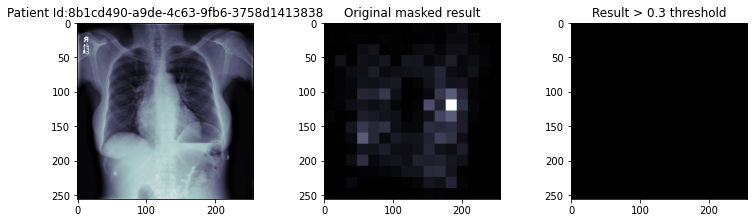

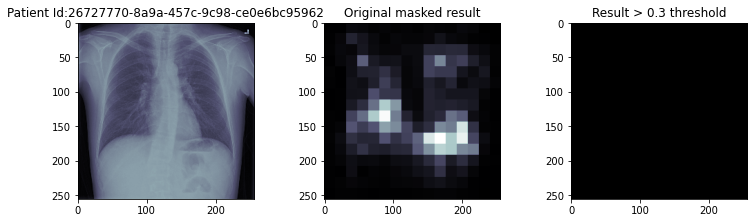

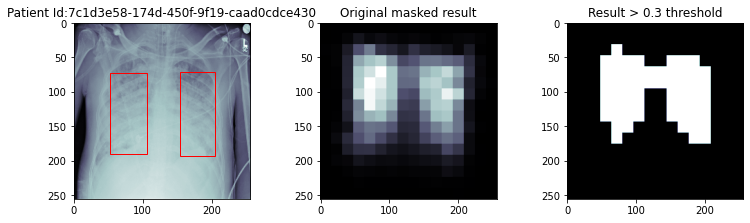

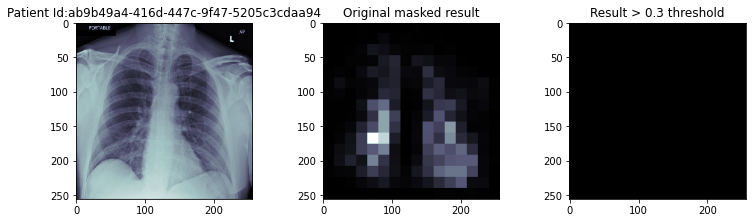

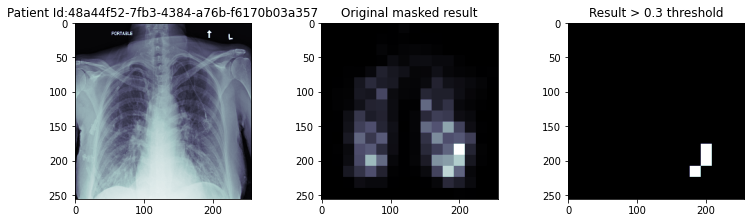

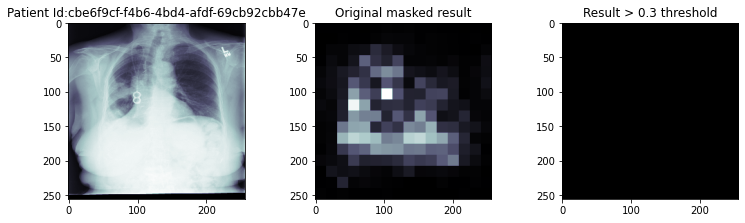

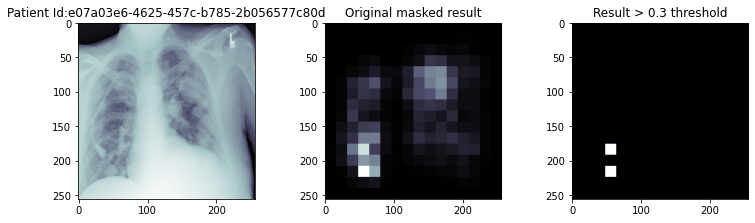

In [108]:
from matplotlib.patches import Rectangle
fileObject_full = open("train_class_df_pickle",'rb')  
train_class_full_df = pickle.load(fileObject_full)
i=0
for info in valid_test_patient_Ids[:10]:
      pat_id = info
      pat_info_list = train_class_full_df[train_class_full_df.patientId == pat_id]

      x, y = test_gen.__getitem__(i)
      #print(y[0] + ' || '+ info.class)
      result = model1.predict(x)
      
      fig = plt.figure(figsize=(12,14))
      fig.subplots_adjust(hspace=0.4, wspace=0.4)
      ax = fig.add_subplot(1, 3, 1)
      
      ax.imshow(np.reshape(x[0], (256, 256)), cmap=plt.cm.bone)
      ax.set_title('Patient Id:' + str(y[0]))
      for pat_info_obj in pat_info_list.iterrows():
            pat_info = pat_info_obj[1]
            
            x_val = pat_info.x/4
            y_val = pat_info.y/4
            width_val = pat_info.width/4
            height_val = pat_info.height/4
            ax.add_patch(Rectangle(xy= (x_val, y_val),
                            width=width_val,height=height_val, 
                            linewidth=1,edgecolor='r',facecolor='none')) 
                            
            
      ax = fig.add_subplot(1, 3, 2)
      result1 = np.where(result > 0.3, 1, 0)
      ax.imshow(np.reshape(result[0], (256, 256)), cmap=plt.cm.bone)
      ax.set_title('Original masked result')
      ax = fig.add_subplot(1, 3, 3)
      ax.imshow(np.reshape(result1[0], (256, 256)), cmap=plt.cm.bone)
      ax.set_title('Result > 0.3 threshold')
      plt.show()

      i = i+1